In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms as trn
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

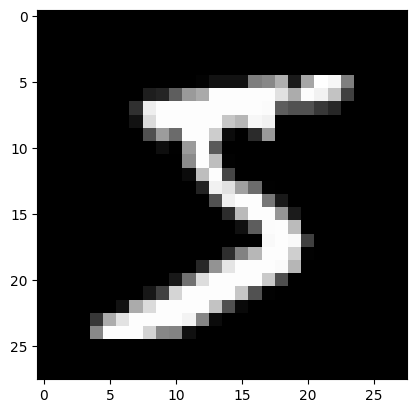

In [3]:
image, lable = dataset[0]
plt.imshow(image[0], cmap='gray')

In [4]:
val_size = 10000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 250
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

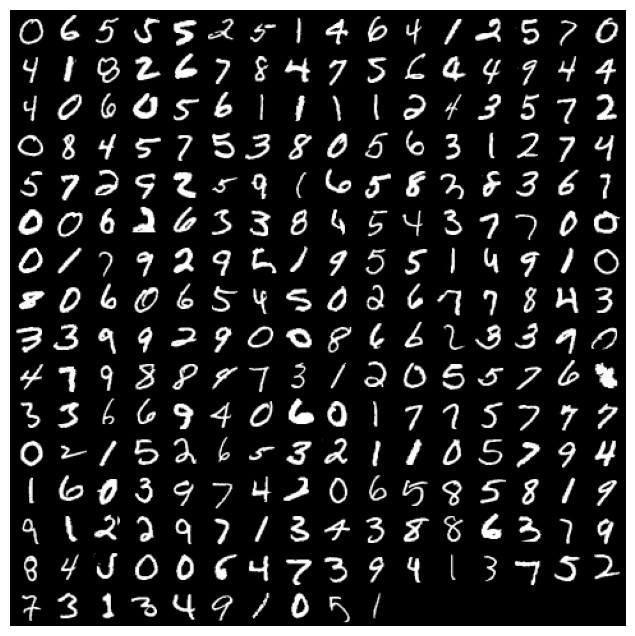

In [6]:
for images,__ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [7]:
for images,__ in train_loader:
    inputs = images.reshape(-1, 784)
    break

In [8]:
input_size = inputs.shape[-1]
hidden_size = 120

In [9]:
layer_01 = nn.Linear(input_size, hidden_size)
inputs.shape

torch.Size([250, 784])

In [10]:
layer_01_op = layer_01(inputs)
relu_outputs = F.relu6(layer_01_op)

In [11]:
output_size = 10
layer_02 = nn.Linear(hidden_size, output_size)

In [12]:
layer_02_op = layer_02(relu_outputs)

In [13]:
def accuracy(ouputs, lables):
    __, preds = torch.max(ouputs, dim=1)
    return torch.tensor(torch.sum(preds == lables).item() / len(preds))

In [14]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [15]:
model = MnistModel(input_size, hidden_size, output_size)
for t in model.parameters():
    print(t.shape)

torch.Size([120, 784])
torch.Size([120])
torch.Size([10, 120])
torch.Size([10])


In [16]:
torch.cuda.is_available()

True

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
device = get_default_device()
device 

device(type='cuda')

In [19]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [22]:
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=10, bias=True)
)

In [23]:
import train
history =[train.evaluate(model, val_loader)]
history

[{'val_loss': 2.3007941246032715, 'val_acc': 0.09970000386238098}]

In [24]:
history = train.fit(100, 0.05, model, train_loader, val_loader, torch.optim.SGD)

Epoch [0], val_loss: 0.5892, val_acc: 0.8601
Epoch [1], val_loss: 0.4185, val_acc: 0.8872
Epoch [2], val_loss: 0.3662, val_acc: 0.8964
Epoch [3], val_loss: 0.3359, val_acc: 0.9032
Epoch [4], val_loss: 0.3171, val_acc: 0.9079
Epoch [5], val_loss: 0.3017, val_acc: 0.9110
Epoch [6], val_loss: 0.2898, val_acc: 0.9151
Epoch [7], val_loss: 0.2788, val_acc: 0.9187
Epoch [8], val_loss: 0.2684, val_acc: 0.9211
Epoch [9], val_loss: 0.2598, val_acc: 0.9240
Epoch [10], val_loss: 0.2513, val_acc: 0.9256
Epoch [11], val_loss: 0.2437, val_acc: 0.9303
Epoch [12], val_loss: 0.2365, val_acc: 0.9313
Epoch [13], val_loss: 0.2286, val_acc: 0.9337
Epoch [14], val_loss: 0.2232, val_acc: 0.9353
Epoch [15], val_loss: 0.2164, val_acc: 0.9370
Epoch [16], val_loss: 0.2135, val_acc: 0.9376
Epoch [17], val_loss: 0.2060, val_acc: 0.9398
Epoch [18], val_loss: 0.1996, val_acc: 0.9418
Epoch [19], val_loss: 0.1946, val_acc: 0.9442
Epoch [20], val_loss: 0.1897, val_acc: 0.9453
Epoch [21], val_loss: 0.1857, val_acc: 0.946

Text(0, 0.5, 'loss')

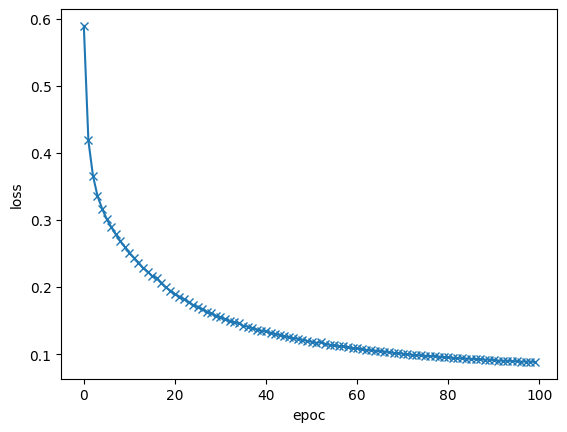

In [25]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoc')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

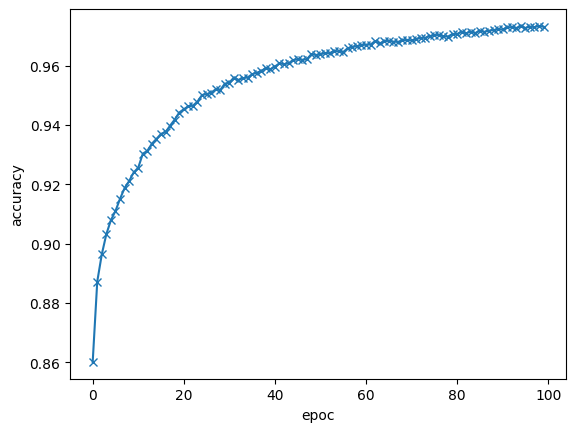

In [26]:
accuracy = [x['val_acc'] for x in history]
plt.plot(accuracy, '-x')
plt.xlabel('epoc')
plt.ylabel('accuracy')

Label: 2 , Prediction:  2


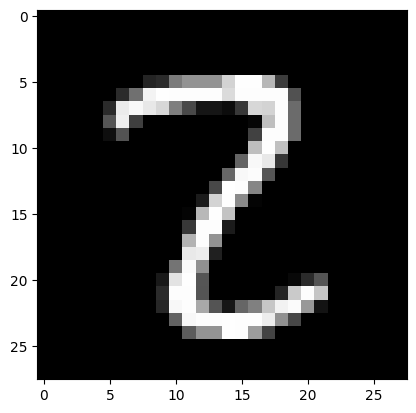

In [27]:
from pred import predict_image as PI
test_dataset = MNIST(root='data/', train= False, transform= trn.ToTensor())
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:',label,', Prediction: ', PI(img, model, device))

In [30]:
import os
#cur_dir = os.path.dirname(os.path.abspath(__file__))
cur_dir = os.getcwd()
save_path = os.path.join(cur_dir, 'models/Saved-number-NN-model-weights.pth')
save_path_md = os.path.join(cur_dir, 'models/Saved-number-NN-model.pt')
torch.save(model.state_dict(),save_path)
torch.save(model, save_path_md)
